In [1]:
import numpy as np
import itertools
# %matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from matplotlib import animation
from matplotlib.patches import Polygon
import cv2

# Let's first define hyperparameters. In our case, we set the image height H and width H to 128 pixels.
H, W = 128, 128

In [2]:
###########################
##### Helper Function #####
###########################
def get_cube(center=(0, 0, 2), rotation_angles=[0., 0., 0.], scale=1.):
    ''' Returns an array containing the faces of a cube.

    Args:
    center (tuple): center of the cube
    rotation_angles (tuple): Euler angles describing the rotation of the cube
    scale (float): scale of cube

    '''
    # A cube consists of 6 faces and 8 corners:
    #   +----+
    #  /    /|
    # +----+ |
    # |    | +
    # |    |/
    # +----+
    # Let's first consider the unit cube. The corners are:
    corners = np.array([(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)])
    # Let's now center the cube at (0, 0, 0)
    corners = corners - np.array([0.5, 0.5, 0.5], dtype=np.float32).reshape(1, 3)
    # Let's scale the cube
    corners = corners * scale
    # And we rotate the cube wrt. the input rotation angles
    rot_mat = R.from_euler('xyz', rotation_angles, degrees=True).as_matrix()
    corners = np.matmul(corners, rot_mat.T)
    # Finally, we shift the cube according to the input center tuple
    corners = corners + np.array(center, dtype=np.float32).reshape(1, 3)

    # The 6 faces of the cube are then given as:
    faces = np.array([
    # all faces containing (0, 0, 0)
    [corners[0], corners[1], corners[3], corners[2]],
    [corners[0], corners[1], corners[5], corners[4]],
    [corners[0], corners[2], corners[6], corners[4]],
    # all faces containing (1, 1, 1)
    [corners[-1], corners[-2], corners[-4], corners[-3]],
    [corners[-1], corners[-2], corners[-6], corners[-5]],
    [corners[-1], corners[-3], corners[-7], corners[-5]],
    ])


    return faces

In [26]:
def get_camera_intrinsics(alpha=70, beta=70, cx=W/2., cy=H/2.):
    ''' Returns the camera intrinsics matrix.

    Hint: The array should be of size 3x3 and of dtype float32 (see the assertion below)

    Args:
    alpha (float): focal length in x-direction f_x
    beta (float): focal length in y-direction f_y
    cx (float): x component of the principal point
    cy (float): y compontent of th principal point
    '''
    # return K
    # Create the camera intrinsic matrix
    K = np.array([[alpha, 0, cx],
                  [0, beta, cy],
                  [0, 0, 1]], dtype=np.float32)

    return K

In [35]:
def get_perspective_projection(x_c, K):
    '''
    Projects the 3D point x_c to screen space and returns the 2D pixel coordinates.
    
    Args:
        x_c (array): 3D points in camera space (nx3), n is the number of points
        K (array): camera intrinsics matrix (3x3)
    Returns:
        numpy.array: The 2D pixel coordinates of the projected points in screen space.
    '''
    # Step 1: Convert 3D points to homogeneous coordinates by adding a column of ones
    # This makes x_c_homogeneous a Nx4 matrix.
    x_c_homogeneous = np.hstack([x_c, np.ones((x_c.shape[0], 1))])
    
    # Step 2: Perform matrix multiplication with the transpose of the homogeneous coordinates.
    # K (3x3) multiplied by x_c_homogeneous.T (4xN) won't work directly because of dimension mismatch.
    # We use slicing to use only the first three rows of the transposed homogeneous coordinates.
    x_s_homogeneous = np.dot(K, x_c_homogeneous.T[:3, :])
    
    # Step 3: Convert back from homogeneous coordinates to 2D by dividing by the last component.
    # x_s_homogeneous will be 3xN, and we take the first two rows and divide by the third row to normalize.
    x_s = x_s_homogeneous[:2, :] / x_s_homogeneous[2, :]
    
    return x_s.T


In [36]:
def project_cube(cube, K):
    ''' Projects the cube.
    
    Args:
        cube (array): cube
        K (array): camera intrinsics matrix
    '''
    # return projected_cube

    # Flatten the cube faces to get all the 3D points in a list
    cube_points = cube.reshape(-1, 3)
    
    # Project each 3D point to 2D using the camera matrix
    projected_points = get_perspective_projection(cube_points, K)
    
    # Reshape back to (6, 4, 2) to represent faces with 2D coordinates
    projected_cube = projected_points.reshape(6, 4, 2)
    
    return projected_cube
    

In [53]:
def plot_projected_cube(projected_cube):
    ''' Plots the projected cube.

    Args:
    projected_cube (array): projected cube (size 6x4x2)
    '''
    plt.figure(figsize=(5,5))
    for face in projected_cube:
        # Close the face by appending the first point to the end
        face = np.vstack([face, face[0]])
        # Fill the face with blue color
        plt.fill(face[:, 0], face[:, 1], '#1f77b4',)

    plt.title('Projected Cube')
    plt.xlabel('Width')
    plt.ylabel('Height')

    # Set x and y axis limits to 0-120
    plt.xlim(0, 130)
    plt.ylim(0, 130)
    # plt.gca().invert_yaxis()  # Invert y-axis for the correct camera image
    plt.show()


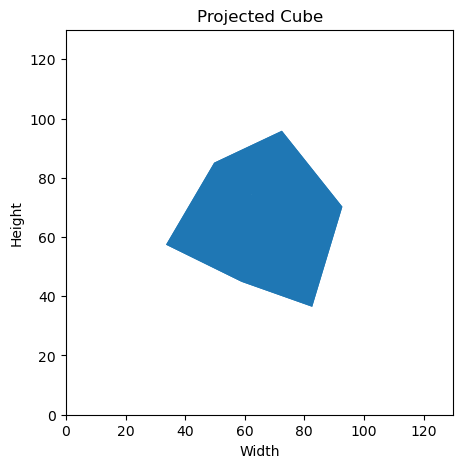

In [54]:
K = get_camera_intrinsics()
cube = get_cube(rotation_angles=[30, 50, 0])
projected_cube = project_cube(cube, K)
plot_projected_cube(projected_cube)

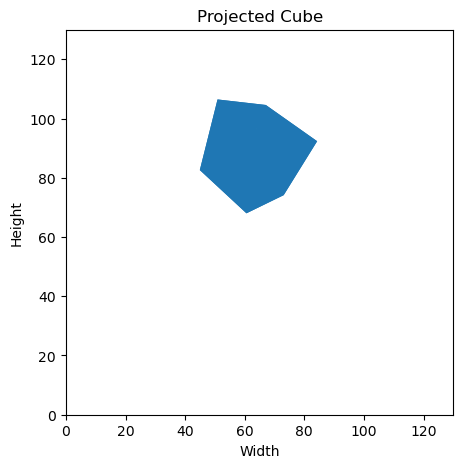

In [56]:
K = get_camera_intrinsics()
cube = get_cube(center=(0,1,3),rotation_angles=[20, 40, 60], scale=1)
projected_cube = project_cube(cube, K)
plot_projected_cube(projected_cube)